# Analysis of Review Time vs Retention and Rating

This notebook explores how real review durations (ms) correlate with FSRS-estimated retrievability and the ratings provided by the user.

In [ ]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm

# Add src to path
sys.path.append(os.path.abspath("../src"))

from fsrs import Card, Scheduler
from statsmodels.miscmodels.ordinal_model import OrderedModel

from anki_utils import get_review_history_stats, infer_review_weights, load_anki_history
from simulate_fsrs import RustOptimizer, run_simulation
from simulation_config import SeededData, SimulationConfig

/home/acbraith/projects/fsrs_experiments/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Shared configuration
REPEATS = int(os.getenv("REPEATS", "5"))
N_DAYS = int(os.getenv("N_DAYS", "180"))
SEED_HISTORY = os.getenv("ANKI_COLLECTION", "../collection.anki2")
DECK_CONFIG = os.getenv("DECK_CONFIG", "ChineseReading")

if SEED_HISTORY and not os.path.exists(SEED_HISTORY):
    SEED_HISTORY = None

## Data Loading and FSRS Fitting

In [3]:
print(f"Loading history for {DECK_CONFIG}...")
logs, last_rev = load_anki_history(SEED_HISTORY, deck_config_name=DECK_CONFIG)
flat_logs = [log for card_logs in logs.values() for log in card_logs]

print(f"Fitting FSRS-6 parameters on {len(flat_logs)} reviews...")
optimizer = RustOptimizer(flat_logs)
fitted_params = tuple(optimizer.compute_optimal_parameters())
print(f"Fitted params: {fitted_params}")

# Pre-calculate card states for seeding
print("Pre-calculating initial card states (replaying history)...")
scheduler = Scheduler(parameters=fitted_params)
true_cards = {}
sys_cards = {}

for cid, card_logs in logs.items():
    true_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)
    sys_cards[cid] = scheduler.reschedule_card(Card(card_id=cid), card_logs)

seeded_data = SeededData(
    logs=logs,
    last_rev=last_rev,
    true_cards=true_cards,
    sys_cards=sys_cards,
)
print("Seeding complete.")

Loading history for ChineseReading...
Anki database version 18 detected.
Querying reviews for 1 matching decks...
Successfully loaded 151862 reviews for 13641 cards.
Review date range: 2019-02-09 to 2026-02-01
Fitting FSRS-6 parameters on 151862 reviews...
Fitted params: (0.0027710397262126207, 1.596158504486084, 15.617354393005371, 15.617354393005371, 6.413300037384033, 0.8334000110626221, 3.019399881362915, 0.0010000000474974513, 1.8722000122070312, 0.16660000383853912, 0.7960000038146973, 1.4835000038146973, 0.061400000005960464, 0.2628999948501587, 1.648300051689148, 0.6014000177383423, 1.8729000091552734, 0.5425000190734863, 0.09120000153779984, 0.0658000037074089, 0.1542000025510788)
Pre-calculating initial card states (replaying history)...
Seeding complete.


In [4]:
stats = get_review_history_stats(logs, fitted_params)
df = pd.DataFrame(stats)
df = df.dropna(subset=["duration"])
assert (df["duration"] == 0).sum() == 0
# Convert duration from ms to seconds for easier reading
df["duration_sec"] = df["duration"] / 1000.0
df["is_new_card"] = df["stability"] == 0
df.head()

,card_id,retention,rating,duration,stability,difficulty,elapsed_days,duration_sec,is_new_card
0,1393817670651,0.519463,4,4539.0,0.000000,3.259772,0.000000,4.539,True
1,1393817670651,0.973745,4,4309.0,15.617354,1.000000,3.916837,4.309,False
2,1393817670651,0.953864,4,5875.0,41.028280,1.000000,15.162529,5.875,False
3,1393817670651,0.958288,4,5133.0,141.698003,1.000000,46.437872,5.133,False
4,1393817670651,0.947379,3,2822.0,396.938120,1.000000,170.931361,2.822,False


## Review Time Estimation
Review time is not constant; it can be more expensive to review certain types of cards.

We fit a linear model to give us more accurate estimates of review time. This will use the card state and FSRS model output (i.e. new/review, stability, difficulty and retention) alongside the rating given to estimate review time.

We use cross-validation and an L1 penalty term to check if any features are not useful for generalisably forecasting review time.

Optimal Alpha: 0.072217
R-squared: 0.0310
--- Coefficients ---
is_new_card: 0.1636
retention: -0.0603
rating: -0.5373
stability: -0.7039
difficulty: -0.1875


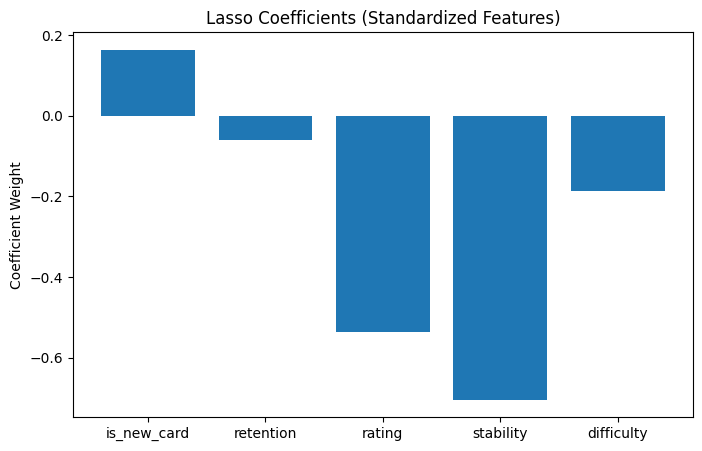

In [6]:
# Prepare features and target
features = ["is_new_card", "retention", "rating", "stability", "difficulty"]
target = "duration_sec"
X = df[features].values
y = df[target].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Lasso with Cross-Validation to select alpha
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

print(f"Optimal Alpha: {lasso.alpha_:.6f}")
print(f"R-squared: {lasso.score(X_scaled, y):.4f}")
print("--- Coefficients ---")
for feat, coef in zip(features, lasso.coef_, strict=False):
    print(f"{feat}: {coef:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(features, lasso.coef_)
plt.title("Lasso Coefficients (Standardized Features)")
plt.ylabel("Coefficient Weight")
plt.show()

## Grade Prediction Model

The FSRS model estimates success/failure of a review. However, success can have various "degrees" (i.e. rating hard, good, easy). Current simulations assume this distribution is uniform across all review cards regardless of card specifics.

That is not true. We use an `OrderedModel` to determine the probability distribution over rating (Hard, Good, Easy) for a given review given that a review was successful (retrieved).

At simulation time we can sample from the distrubiton given by this `OrderedModel` rather than assuming the same probability distrubiton for all reviews.

In [7]:
# Filter for successful reviews (Rating > 1)
df_success = df[df["rating"] > 1].copy()

# OrderedModel needs at least 2 unique categories and enough data
if len(df_success) >= 10 and df_success["rating"].nunique() > 1:
    # Features for grade prediction
    grade_features = ["is_new_card", "retention", "stability", "difficulty"]
    X_grade = df_success[grade_features].values
    y_grade = df_success["rating"].values

    # Standardize features
    scaler_grade = StandardScaler()
    X_grade_scaled = scaler_grade.fit_transform(X_grade)

    # Fit OrderedModel
    try:
        mod_prob = OrderedModel(y_grade, X_grade_scaled, distr="probit")
        res_prob = mod_prob.fit(method="bfgs", disp=False)
        print(res_prob.summary())
        HAS_GRADE_MODEL = True
    except Exception as e:
        print(f"Failed to fit OrderedModel: {e}")
        HAS_GRADE_MODEL = False
else:
    print("Insufficient data for OrderedModel, falling back to simple weights.")
    HAS_GRADE_MODEL = False


def predict_grades_batch(features_list, weights, count):
    if HAS_GRADE_MODEL and features_list:
        x_features = np.array(features_list)
        x_scaled = scaler_grade.transform(x_features)
        probs_all = res_prob.predict(x_scaled)

        # Vectorized weighted random choice
        # cumsum along axis 1 gives cumulative probabilities
        # we compare against random draws
        cum_probs = probs_all.cumsum(axis=1)
        r = np.random.rand(len(probs_all), 1)
        # Count how many thresholds we haven't crossed yet.
        # This logic finds the index where r falls.
        # Example: probs=[0.2, 0.5, 0.3] -> cum=[0.2, 0.7, 1.0]
        # r=0.1 -> <0.2, <0.7, <1.0 -> sum=3? No.
        # We want index i such that cum[i-1] <= r < cum[i]
        # Standard trick: (cum_probs < r).sum(axis=1)
        choice_indices = (cum_probs < r).sum(axis=1)
        # Clip to ensure valid indices (just in case of float precision issues)
        choice_indices = np.minimum(choice_indices, len(res_prob.model.labels) - 1)

        return res_prob.model.labels[choice_indices].tolist()
    else:
        # Fallback to simple success weights
        return np.random.choice([2, 3, 4], size=count, p=weights.success).tolist()

                             OrderedModel Results                             
Dep. Variable:                      y   Log-Likelihood:                -73535.
Model:                   OrderedModel   AIC:                         1.471e+05
Method:            Maximum Likelihood   BIC:                         1.471e+05
Date:                Tue, 03 Feb 2026                                         
Time:                        11:20:54                                         
No. Observations:              117555                                         
Df Residuals:                  117549                                         
Df Model:                           4                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0300      0.004      6.888      0.000       0.021       0.038
x2             0.1203      0.004     26.795      0.0

## Improved Optimal Retention
Current optimal retention assumes all reviews are equal. We can now estimate the true cost (in time) of a review.

Let's run simulations using these estimates for review times based on card state at time of review to see the impact this has on optimal retention.

Note these simulations are also applying the post-processing discussed in the [Optimal Retention notebook](notebooks/Optimal_Retention.ipynb).

In [ ]:
from anki_utils import (
    calculate_expected_d0,
)

# Baseline features for new cards (matches get_review_history_stats)
weights = infer_review_weights(logs)
w_first = weights.first
prob_first_success = 1.0 - w_first[0]
expected_d0 = calculate_expected_d0(w_first, fitted_params)


def lasso_time_estimator(cards, current_date, ratings, nature_scheduler):
    features_list = []
    for card, rating in zip(cards, ratings, strict=False):
        s = card.stability

        if s is None or s == 0:
            # Brand new card features
            ret = prob_first_success
            s_feat = 0.0
            d_feat = expected_d0
            is_new = True
        else:
            ret = nature_scheduler.get_card_retrievability(card, current_date)
            s_feat = s
            d_feat = card.difficulty
            is_new = False

        features_list.append([int(is_new), ret, int(rating), s_feat, d_feat])

    if not features_list:
        return []

    x_features = np.array(features_list)
    x_scaled = scaler.transform(x_features)
    pred_secs = lasso.predict(x_scaled)
    return np.maximum(0.5, pred_secs).tolist()  # Floor at 0.5s

In [ ]:
daily_budget_sec = 30 * 60
mean_duration_sec = df["duration_sec"].mean()

retentions = [0.1, 0.3, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


def constant_time_estimator(cards, current_date, ratings, nature_scheduler):
    return [mean_duration_sec] * len(cards)


def advanced_rating_estimator(true_cards, date, nature_scheduler):
    count = len(true_cards)
    results = [0] * count

    # 1. Batch calculate retrievability (loop is fast enough, 0.8us/card)
    rets = [nature_scheduler.get_card_retrievability(c, date) for c in true_cards]

    # 2. Vectorized random check for forgetting
    rands = np.random.random(count)
    # If rand > ret, we forget (1)
    is_forget = rands > rets

    # Assign 'Again' (1) to forgotten cards
    # We can use numpy to assign, but results is a list.
    # Let's iterate once to build success features and assign fails.

    success_features = []
    success_indices = []

    for i in range(count):
        if is_forget[i]:
            results[i] = 1
        else:
            c = true_cards[i]
            s = c.stability or 0.0
            d = c.difficulty or expected_d0
            is_new = s == 0
            success_features.append([int(is_new), rets[i], s, d])
            success_indices.append(i)

    if success_indices:
        grades = predict_grades_batch(success_features, weights, len(success_indices))
        for idx, grade in zip(success_indices, grades, strict=False):
            results[idx] = grade

    return results


results_constant = []
results_lasso = []
results_advanced = []

for ret in tqdm(retentions, desc="Simulating"):
    # 1. Constant Time Estimator
    config_const = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=constant_time_estimator,
        verbose=False,
    )
    _, _, metrics_const = run_simulation(
        config_const,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_constant.append(metrics_const)

    # 2. Lasso Model Time Estimator (Default Rating)
    config_lasso = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        verbose=False,
    )
    _, _, metrics_lasso = run_simulation(
        config_lasso,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_lasso.append(metrics_lasso)

    # 3. Advanced Estimator (OrderedModel Grade + Lasso Duration)
    config_adv = SimulationConfig(
        n_days=N_DAYS,
        retention=str(ret),
        review_limit=None,
        new_limit=None,
        time_limit=daily_budget_sec,
        time_estimator=lasso_time_estimator,
        rating_estimator=advanced_rating_estimator,
        verbose=False,
    )
    _, _, metrics_adv = run_simulation(
        config_adv,
        seeded_data=seeded_data,
        ground_truth=fitted_params,
        initial_params=fitted_params,
    )
    results_advanced.append(metrics_adv)

print("Simulations complete.")

Simulating: 100%|██████████| 10/10 [29:25<00:00, 176.58s/it]

Simulations complete.


In [10]:
# 1. Determine N_max (baseline population size)
max_cards = max(
    m["card_count"] for m in results_lasso + results_constant + results_advanced
)

# 2. Baseline retention for unseen cards
r_baseline = prob_first_success


def get_adjusted_total(metrics_list, max_n, r_base):
    adjusted = []
    for m in metrics_list:
        # Current sum of retention for studied cards
        current_total = m["total_retention"]
        # Add hypothetical retention for cards we "could have" studied
        missing_cards = max_n - m["card_count"]
        # Ensure we don't subtract if a run somehow exceeded the max (unlikely)
        padding = max(0, missing_cards) * r_base
        adjusted.append(current_total + padding)
    return adjusted


adj_results_constant = get_adjusted_total(results_constant, max_cards, r_baseline)
adj_results_lasso = get_adjusted_total(results_lasso, max_cards, r_baseline)
adj_results_advanced = get_adjusted_total(results_advanced, max_cards, r_baseline)

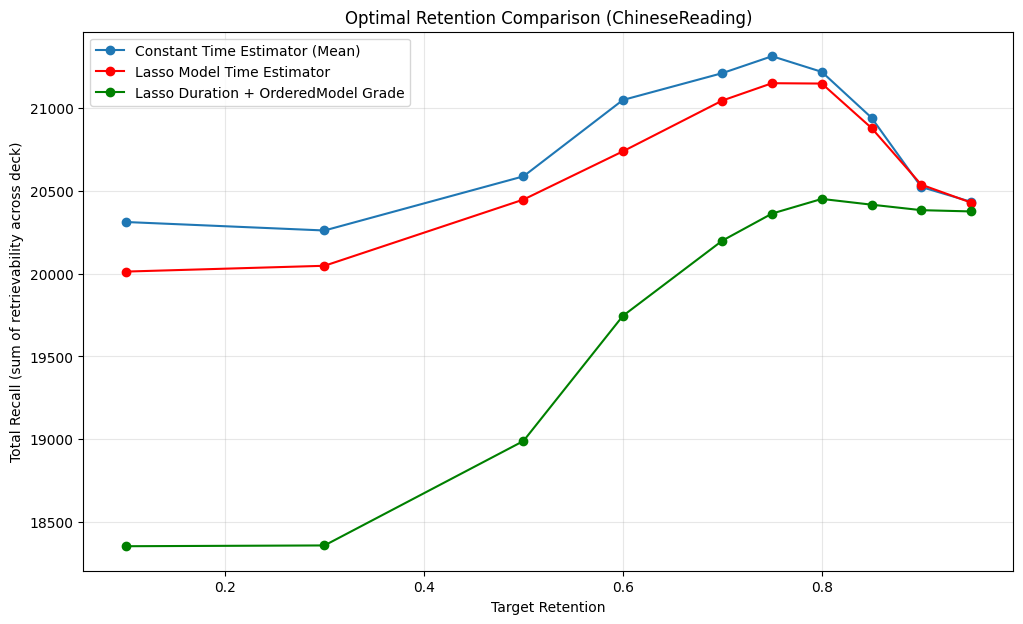

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(
    retentions, adj_results_constant, marker="o", label="Constant Time Estimator (Mean)"
)
plt.plot(
    retentions,
    adj_results_lasso,
    marker="o",
    color="red",
    label="Lasso Model Time Estimator",
)
plt.plot(
    retentions,
    adj_results_advanced,
    marker="o",
    color="green",
    label="OrderedModel Grade + Lasso Duration",
)

plt.title(f"Optimal Retention Comparison ({DECK_CONFIG})")
plt.xlabel("Target Retention")
plt.ylabel("Total Recall (sum of retrievability across deck)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()